# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


In [2]:
%pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#hourly energy consumption data to accurately predict energy usage in the future.

Dataset link: https://drive.google.com/file/d/1rdE0MtC3oN85i3zF7Uff9eBnBkRiqW5U/view?usp=sharing

In [13]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [14]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


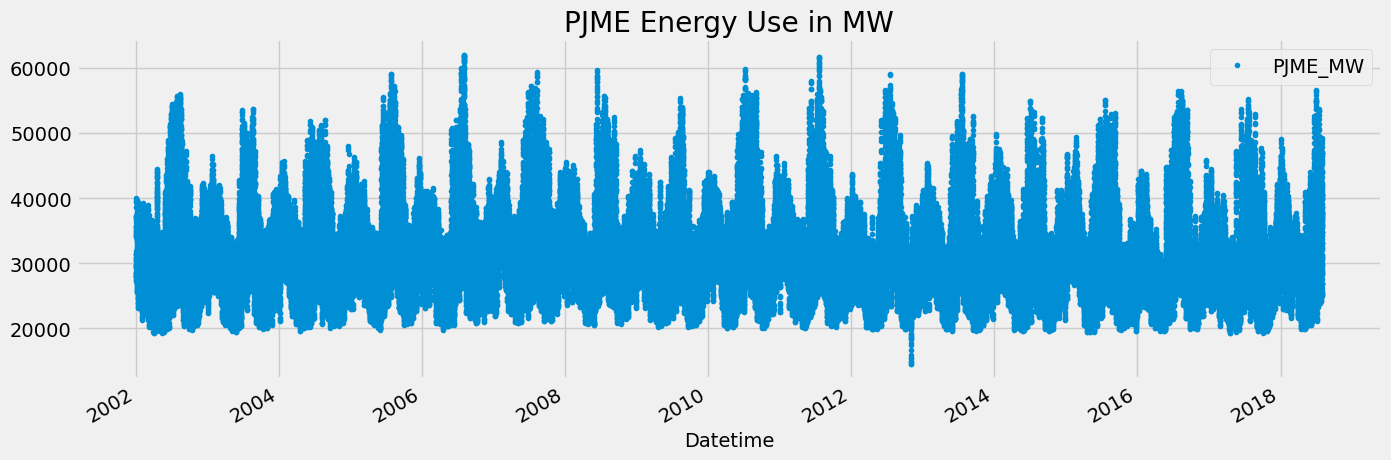

In [15]:
#plotting the data
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt. show()

# Train / Test Split

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


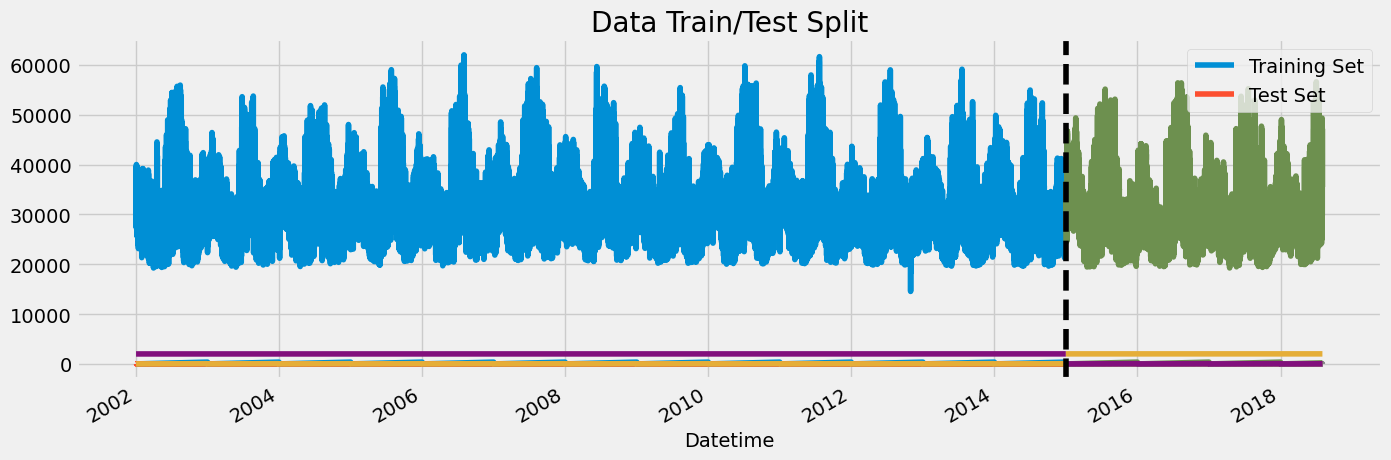

In [40]:
# Splitting the data into training and test sets
train = df.loc[df.index < pd.to_datetime('01-01-2015')]
test = df.loc[df.index >= pd.to_datetime('01-01-2015')]

# Plotting the training and test sets
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


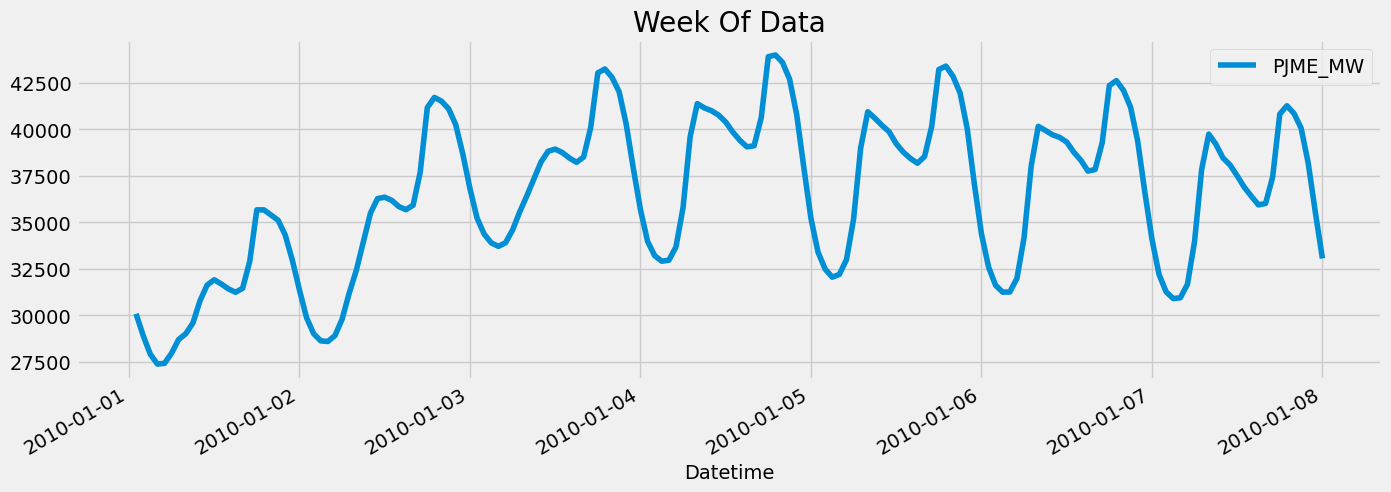

In [22]:
#plotting the data of a week
df.loc[(df.index > '01-01-2010') &(df.index <='01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [43]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    return df

df = create_features(df)


In [44]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


# Visualize our Feature / Target Relationship

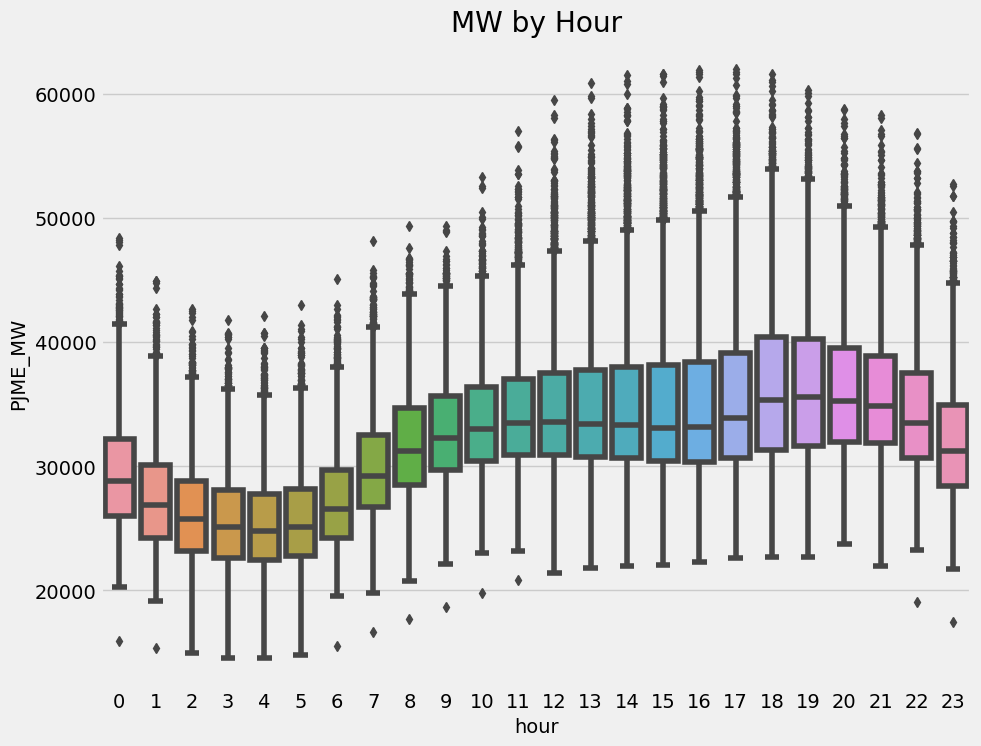

In [45]:
#MW by Hour
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax)
ax.set_title('MW by Hour')
plt.show()


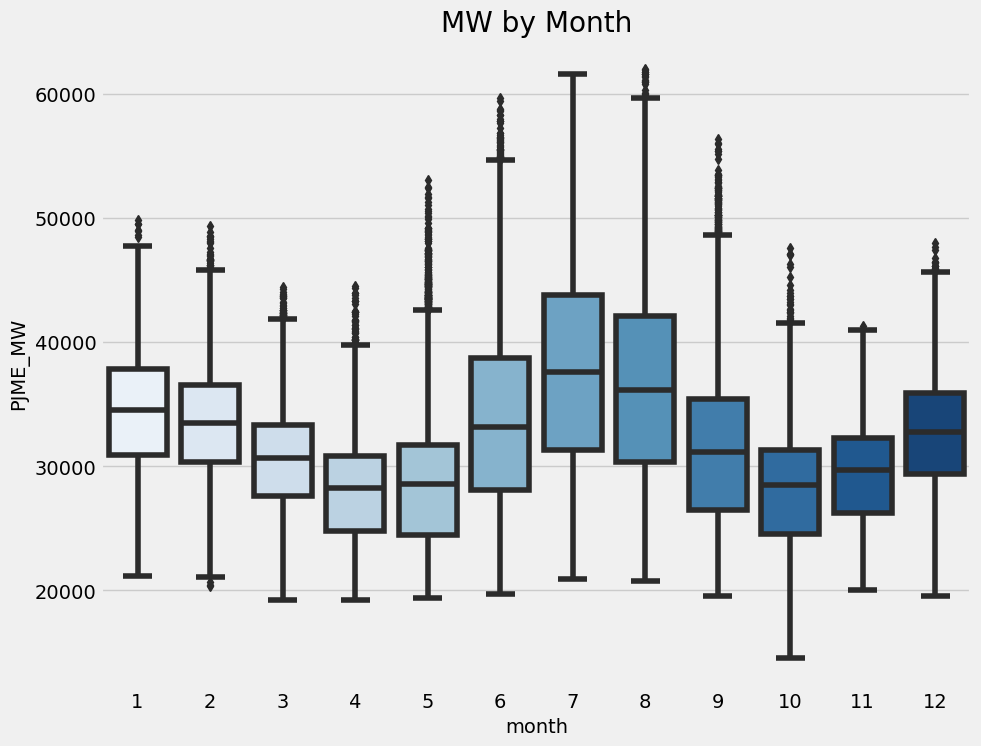

In [46]:
#MW by Month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues', ax=ax)
ax.set_title('MW by Month')
plt.show()


# Create our Model

In [47]:
# Assuming 'train' and 'test' are the DataFrames for the training and test datasets, respectively

# Create time series features for the training dataset
train = create_features(train)
# Create time series features for the test dataset
test = create_features(test)

# List of features
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth', 'weekofyear']

# Target variable
TARGET = 'PJME_MW'

# Splitting the training dataset into input features (X_train) and target variable (y_train)
X_train = train[FEATURES]
y_train = train[TARGET]

# Extracting the input features (X_test) and target variable (y_test) from the test dataset
X_test = test[FEATURES]
y_test = test[TARGET]


In [48]:
X_test

,dayofyear,hour,dayofweek,quarter,month,year,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-01-01 00:00:00,1,0,3,1,1,2015,1,1
2015-12-31 01:00:00,365,1,3,4,12,2015,31,53
2015-12-31 02:00:00,365,2,3,4,12,2015,31,53
2015-12-31 03:00:00,365,3,3,4,12,2015,31,53
2015-12-31 04:00:00,365,4,3,4,12,2015,31,53
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,1,20,0,1,1,2018,1,1
2018-01-01 21:00:00,1,21,0,1,1,2018,1,1
2018-01-01 22:00:00,1,22,0,1,1,2018,1,1


In [49]:
y_test

Datetime
2015-01-01 00:00:00    32802.0
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 31440, dtype: float64

# Prediction using XGBoost Algorithm

The XGBoost is an algorithm known for its speed, scalability, and performance.it is able to solve classification problems and produce reasonable forecasts right out of the box with no hyperparameter tuning. 

*brief overview of how XGBoost works:XGBoost combines multiple weak predictive models(Ensemble Learning), called decision trees, to create a powerful ensemble model. Each decision tree contributes to the final prediction by making a sequence of decisions based on the input features.

*Regularization: XGBoost incorporates regularization techniques to prevent overfitting. It applies penalties on the model's complexity to avoid excessively complex models that may fit the training data too closely but generalize poorly to new data.

*Feature Importance: XGBoost provides a measure of feature importance, allowing you to understand which input features have the most significant impact on the predictions. This information can be helpful for feature selection and understanding the underlying patterns in the data.

**RandomForest is a bagging technique that trains multiple decision trees in parallel and determines the final output via a majority vote. XGBoost is a boosting technique that sequentially creates decision trees, each tree improving upon the mistakes of the previous one. The final result is a sum of outputs from all the trees.

![](https://media.geeksforgeeks.org/wp-content/uploads/20210707140912/Bagging.png)

In [50]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:13:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21026	validation_1-rmse:11743.71599
[200]	validation_0-rmse:5833.47946	validation_1-rmse:5362.26584
[300]	validation_0-rmse:3918.79920	validation_1-rmse:4006.74799
[400]	validation_0-rmse:3445.04914	validation_1-rmse:3847.88286
[500]	validation_0-rmse:3283.83013	validation_1-rmse:3814.08687
[600]	validation_0-rmse:3201.73462	validation_1-rmse:3782.19793
[700]	validation_0-rmse:3148.19068	validation_1-rmse:3762.66510
[800]	validation_0-rmse:3108.75293	validation_1-rmse:3747.16990
[900]	validation_0-rmse:3075.50900	validation_1-rmse:3736.67451
[999]	validation_0-rmse:3048.78116	validation_1-rmse:3728.50794


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

xgboost provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model

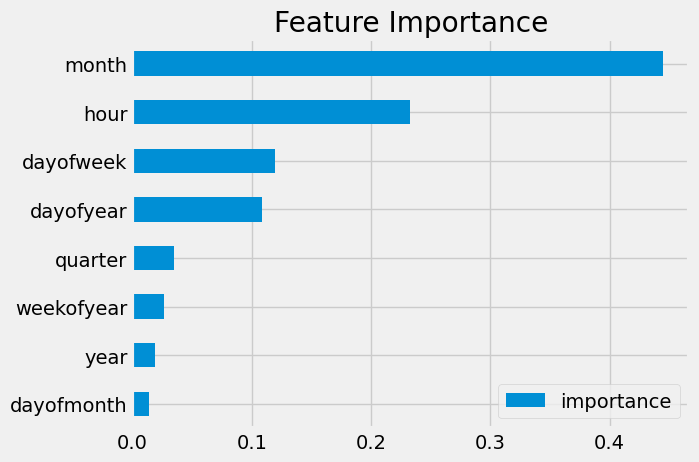

In [51]:
fi = pd.DataFrame(data=reg.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Forecast on Test

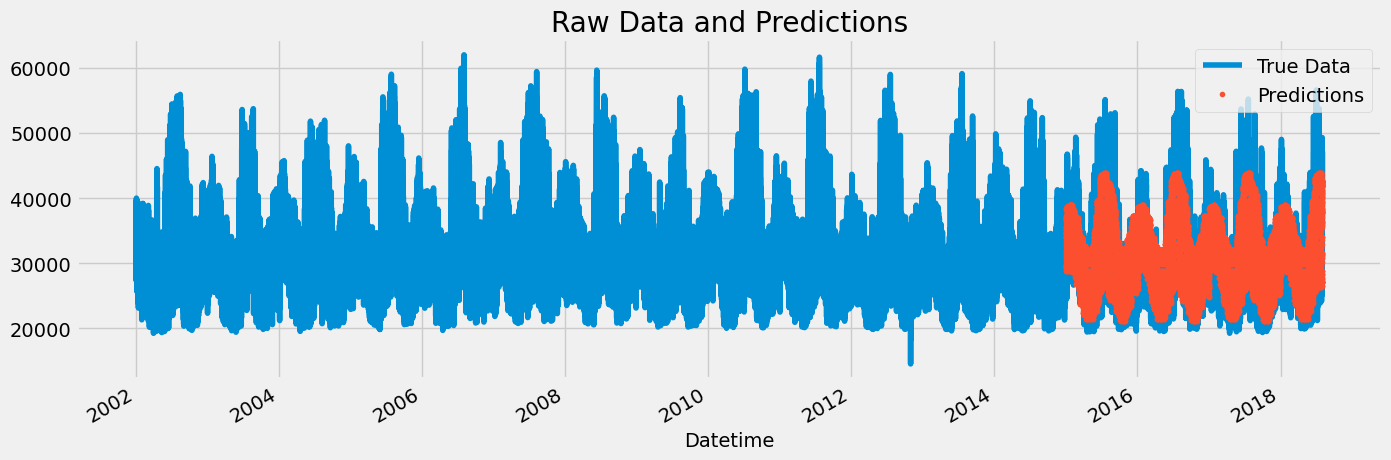

In [52]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


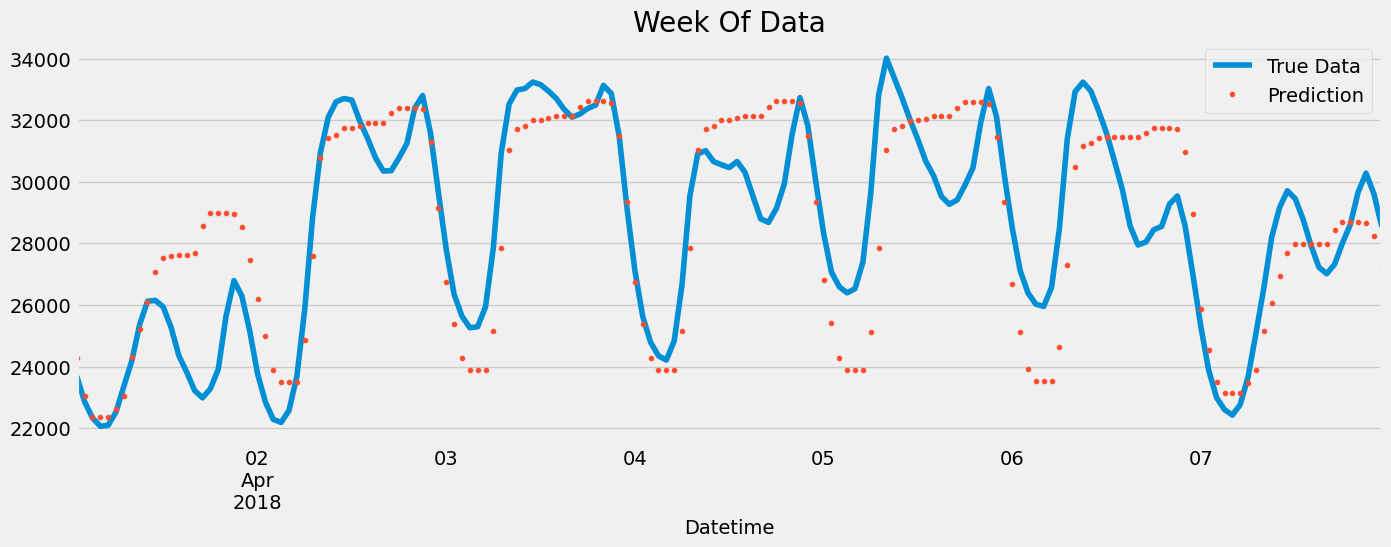

In [53]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['True Data', 'Prediction'])
plt.show()


# Score (RMSE)

In [ ]:
#plot the Test dataframe

In [54]:
#The lower the value of the Root Mean Squared Error, the better the model is.
score = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 3728.48


# Time series clustering with tslearn

In this notebook we will use the `tslearn` library to cluster time series (stocks) from the NDX100.

tslearn is a Python library specifically designed for time series analysis and machine learning tasks

tslearn Kmeans which is helpful in clustering time series data of different length 

In [57]:
# import libraries
import matplotlib
import requests
#
import datetime as dt
import pandas as pd
import numpy as np
#import yfinance as yf
#
from datetime import datetime
from matplotlib import pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

In [56]:
%pip install tslearn

     -------------------------------------- 358.2/358.2 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


dataset link: https://drive.google.com/file/d/1QiRXmfCUk3Wxaz5TRgeOPpdtjthGqbZm/view

In [59]:
df=pd.read_csv('stocks.csv', sep=',',index_col="Date") 

In [60]:
df

,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,ANSS,ASML,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-06-05,0.996921,1.004106,0.995153,0.998698,0.970390,0.998016,0.982639,1.009444,1.027099,1.009726,...,1.024909,1.010870,0.984282,0.982229,1.000370,1.003440,0.968230,0.996382,0.993240,1.002144
2012-06-06,1.019871,1.011535,1.019709,1.019531,1.027591,1.030754,1.026042,1.015494,1.060515,1.032119,...,1.099637,1.032609,1.011177,1.001615,1.025527,1.005375,0.991931,1.005592,1.009013,1.015011
2012-06-07,1.057935,1.049658,1.081422,1.030990,1.070660,1.068452,1.059028,1.039988,1.089942,1.092513,...,1.142190,1.038043,1.028991,1.017771,1.068812,1.022146,0.982014,1.023026,1.041991,1.026090
2012-06-08,1.030787,1.036168,1.048788,1.030469,1.014805,1.050595,0.994792,1.012690,1.070490,1.063560,...,1.156720,1.005435,1.008732,1.001615,1.038476,1.011825,0.959825,1.015789,1.030725,1.011794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,5.084803,4.788476,6.335380,2.383333,10.329745,11.460317,16.739582,3.465988,4.926018,14.801629,...,10.396471,1.875000,12.946560,11.510501,6.097299,4.606536,5.849722,1.038487,0.543166,2.481415
2023-05-11,5.048978,4.759973,6.336672,2.380729,10.209623,11.438492,17.041667,3.462447,4.916542,14.720200,...,10.407888,1.836957,12.939924,11.447496,6.003330,4.612126,5.892923,1.035526,0.513903,2.471408
2023-05-12,5.078086,4.693170,6.256543,2.380729,9.985868,11.578373,16.810764,3.438542,4.922028,14.687628,...,10.352880,1.983696,12.873908,11.546849,5.997410,4.641153,5.890402,1.030921,0.496265,2.465333


# 2. Plot the Elbow Curve

Our first decision is to choose how many clusters do we actually want to separate the data into. Rather than make some arbitrary decision we can use an “Elbow Curve” to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters.

We then plot this relationship to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

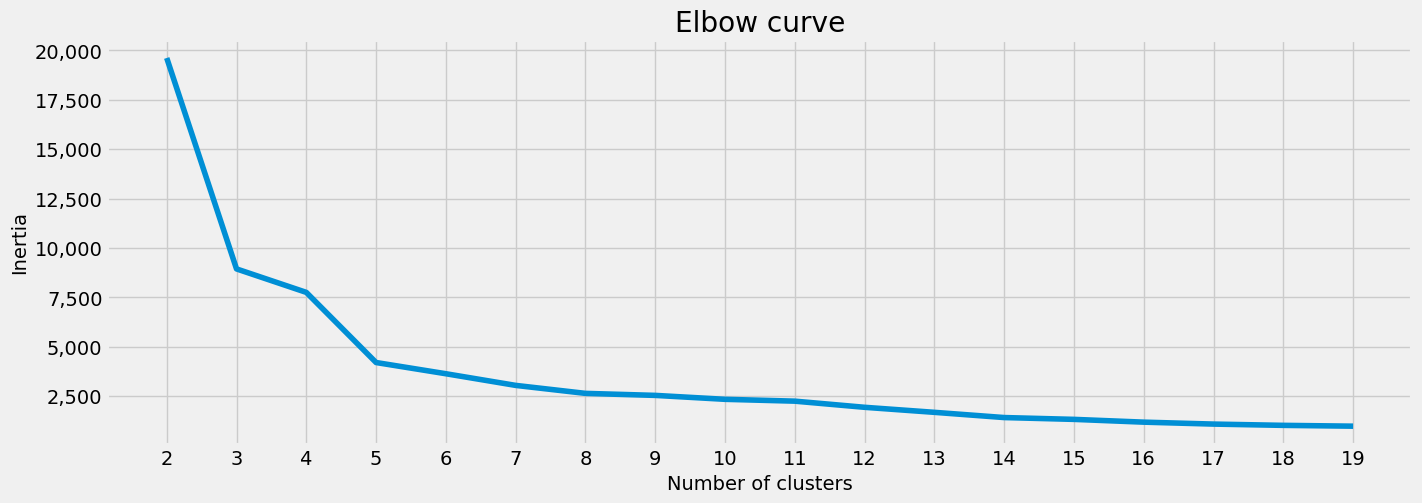

In [61]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

distortions = []
for k in range(2, 20):
    tskm = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10000, random_state=0)
    tskm.fit(df.transpose().values)
    distortions.append(tskm.inertia_)

# Plotting the elbow curve
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.xticks(np.arange(2, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig('Elbow_curve.png')
plt.show()
plt.close()


So we can see that once the number of clusters reaches ... or ... (on the bottom axis), the reduction in the objective function (SSE, Cluster Inertia) begins to slow down for each increase in cluster number. 
we will apply kmeans using ... as then number of clusters .calculate the silhouette score, the apply kmeans using ... as the number of clusters and calculate the silhouette score to reflect th godness of clustering

# 3. Clustering model

In [24]:
model = TimeSeriesKMeans(n_clusters=..., metric="...", max_iter=10000, random_state=0).fit(df.transpose().values)
labels = model. ..._

In [25]:
labels

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0], dtype=int64)

# Evaluate the quality of the clustering

In [ ]:
from sklearn.metrics import silhouette_score
...


# 4. Plot the clusters

In [ ]:
df_cluster = pd.DataFrame(list(zip(df.columns, model.labels_)), columns=['symbol', 'cluster'])
for k in set(labels):
    cluster = df_cluster.loc[df_cluster['cluster']==k]
    stocks = cluster['symbol']
    stocks = df[stocks]
    stocks.plot(y=stocks.columns,figsize=(18, 10))
    # plt.tight_layout()
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), fancybox=True, shadow=True, fontsize=7)
    plt.ylabel('Normalised Return')
    plt.xlabel('Date')
    plt.savefig(f'cluster_{k}.png')
    plt.show()
    plt.close()

As it is typical with clustering you are always going to get some pretty bad random looking ones.